# Quality Control and ASV table construction with DADA2

## Setup and settings

In [1]:
# Importing packages
import os
import yaml
import logging
import pandas as pd
from qiime2 import Artifact
from qiime2 import Visualization
from qiime2 import Metadata
import qiime2.plugins.dada2.actions as dada2_actions
import qiime2.plugins.metadata.actions as metadata_actions
from qiime2.plugins.feature_table.visualizers import tabulate_seqs
from qiime2.plugins.feature_table.visualizers import summarize
from qiime2.plugins.feature_table.visualizers import core_features
from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.methods import filter_seqs

import matplotlib.pyplot as plt

%matplotlib inline

### Receiving the parameters

The following cell can receive parameters using the [papermill](https://papermill.readthedocs.io/en/latest/) tool.

In [2]:
experiment_name = 'ana-flavia-superlactacao'
base_dir = os.path.join('/', 'home', 'lauro', 'nupeb', 'redemicro')
metadata_file = os.path.join(base_dir, 'data', 'raw', 'metadata', 'sample-metadata.tsv')
manifest_file = os.path.join(base_dir, 'data', 'raw', 'manifest', 'sample-manifest.csv')
replace_files = False
phred = 20
trunc_f = 0
trunc_r = 0
overlap = 12
threads = 6
trim = None

In [3]:
# Parameters
experiment_name = "thayane-PM-paired-end-trim"
base_dir = "/home/lauro/nupeb/rede-micro/redemicro-thayane"
manifest_file = (
    "/home/lauro/nupeb/rede-micro/redemicro-thayane/data/manifest-paired.csv"
)
metadata_file = (
    "/home/lauro/nupeb/rede-micro/redemicro-thayane/data/paired-end-metadata.tsv"
)
class_col = "above_10"
classifier_file = (
    "/home/lauro/nupeb/16S_classifiers_qiime2/silva-138-99-nb-classifier.qza"
)
replace_files = False
phred = 20
trunc_f = 0
trunc_r = 0
overlap = 12
threads = 6
trim = {
    "overlap": 8,
    "forward_primer": "CCTACGGGRSGCAGCAG",
    "reverse_primer": "GGACTACHVGGGTWTCTAAT",
}


In [4]:
# Setting hardcoded parameters for development and debbuging
production = True
if not production:
    params_path = os.path.join('..', 'params', 'ana-flavia-superlactacao.yaml')
    with open(params_path, 'r') as stream:
        params = yaml.safe_load(stream)
        experiment_name = params['experiment_name']
        base_dir = params['base_dir']
        replace_files = params['replace_files']
        experiment_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'experiments', 'thayane-feces-01'))
        img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
        replace_files = False
        phred = 20
        trunc_f = 0
        trunc_r = 0
        overlap = 12
        threads = 6

In [5]:
experiment_folder = os.path.abspath(os.path.join(base_dir, 'experiments', experiment_name))
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))

### Defining names and paths

In [6]:
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')

if trim:
    demux_file = os.path.join(qiime_folder, 'demux-paired-trim.qza')
else:
    demux_file = os.path.join(qiime_folder, 'demux-paired.qza')

dada2_tabs = os.path.join(qiime_folder, 'dada2-tabs.qza')
dada2_reps = os.path.join(qiime_folder, 'dada2-reps.qza')
dada2_stat = os.path.join(qiime_folder, 'dada2-stat.qza')


dada2_tabs_view = dada2_tabs[:-1] + 'v'
dada2_reps_view = dada2_reps[:-1] + 'v'
dada2_stat_view = dada2_stat[:-1] + 'v'
dada2_core_view = os.path.join(qiime_folder, 'dada2-core.qzv')

## Step execution

### Load input files

This Step import the QIIME2 `SampleData[PairedEndSequencesWithQuality]` Artifact with all demultiplexed sequences and the `Metadata` file.

In [7]:
need_dada2 = not (os.path.isfile(dada2_tabs) and os.path.isfile(dada2_reps) and os.path.isfile(dada2_stat)) or replace_files
need_view = not (os.path.isfile(dada2_tabs_view) and os.path.isfile(dada2_reps_view) and os.path.isfile(dada2_stat_view)) or replace_files

In [8]:
if need_dada2:
    demux = Artifact.load(demux_file)

In [9]:
metadata = Metadata.load(metadata_file)

In [10]:
# Determine if is SingleEnd or PairedEnd
manifest_df = pd.read_csv(manifest_file)
n_directions = len(manifest_df['direction'].unique())

### Execute DADA2 plugin and create Artifacts

The DADA2 plugin perform tha quality control and create the ASV table. It will be produced three Artifacts:

- tabs (`FeatureTable[Frequency]`) : 
    The resulting feature table.
- reps (`FeatureData[Sequence]`) :
    The resulting feature sequences. Each feature in the feature table will
    be represented by exactly one sequence, and these sequences will be the
    joined paired-end sequences.
- denoising_stats (`SampleData[DADA2Stats]`) : the resulting stats. Shows the number and the proportion of filtered reads in each phase of the plugin execution.

In [11]:
# If some of the DADA2 outputs artifacts do not exist or if the old files will be replaced
if need_dada2:
    
    # Excute the DADA2 plugin
    if n_directions == 1: # SingleEnd
        tabs, reps, stat = dada2_actions.denoise_single(
            demultiplexed_seqs=demux,
            trunc_q = phred,
            n_threads = threads,
            trunc_len = trunc_f,
        )
    elif n_directions == 2: # PairedEnd
        tabs, reps, stat = dada2_actions.denoise_paired(
            demultiplexed_seqs=demux,
            trunc_q = phred,
            min_overlap = overlap,
            n_threads = threads,
            trunc_len_f = trunc_f,
            trunc_len_r = trunc_r,
        )
    
    # Save the artifacts objects
    tabs.save(dada2_tabs)
    reps.save(dada2_reps)
    stat.save(dada2_stat)

else:
    tabs = Artifact.load(dada2_tabs)
    reps = Artifact.load(dada2_reps)
    stat = Artifact.load(dada2_stat)

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: run_dada_paired.R /tmp/tmp_phi63e2/forward /tmp/tmp_phi63e2/reverse /tmp/tmp_phi63e2/output.tsv.biom /tmp/tmp_phi63e2/track.tsv /tmp/tmp_phi63e2/filt_f /tmp/tmp_phi63e2/filt_r 0 0 0 0 2.0 2.0 20 12 independent consensus 1.0 6 1000000



R version 4.1.2 (2021-11-01) 


Loading required package: Rcpp


DADA2: 1.22.0 / Rcpp: 1.0.8.2 / RcppParallel: 5.1.5 
1) Filtering 

......................................
2) Learning Error Rates


226117663 total bases in 1011154 reads from 12 samples will be used for learning the error rates.


154218111 total bases in 1011154 reads from 12 samples will be used for learning the error rates.


3) Denoise samples 

..

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.
.

.

.

.

Duplicate sequences in merged output.


.

Duplicate sequences in merged output.


.

.

.

Duplicate sequences in merged output.


.

.

.

Duplicate sequences in merged output.


.

.

.

.

.

Duplicate sequences in merged output.


.

Duplicate sequences in merged output.


.

Duplicate sequences in merged output.


.

.

.

Duplicate sequences in merged output.


.

Duplicate sequences in merged output.


.

Duplicate sequences in merged output.


.

Duplicate sequences in merged output.


.

.

.

Duplicate sequences in merged output.


.

Duplicate sequences in merged output.


.

.

.

Duplicate sequences in merged output.


.

.

Duplicate sequences in merged output.


.

Duplicate sequences in merged output.


.

Duplicate sequences in merged output.


.

.

Duplicate sequences in merged output.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.


.
4) Remove chimeras (method = consensus)


6) Write output


### Filter samples

In [12]:
# Filter FeatureTable[Frequency | RelativeFrequency | PresenceAbsence | Composition] based on Metadata sample ID values
tabs = filter_samples(
    table=tabs,
    metadata=metadata,
).filtered_table
# Filter SampleData[SequencesWithQuality | PairedEndSequencesWithQuality | JoinedSequencesWithQuality] based on Metadata sample ID values; returns FeatureData[Sequence | AlignedSequence]
reps = filter_seqs(
    data=reps,
    table=tabs,
).filtered_data

### Define Visualizations Artifacts

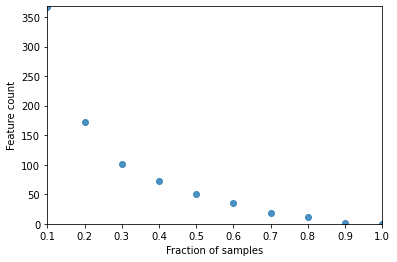

In [13]:
# If some of the DADA2 Visualization artifacts do not exist or if the old files will be replaced
if need_view:
    
    tabs_view, = metadata_actions.tabulate(input=tabs.view(Metadata))
    reps_view, = metadata_actions.tabulate(input=reps.view(Metadata))
    stat_view, = metadata_actions.tabulate(input=stat.view(Metadata))
    
    tabs_view = summarize(table=tabs, sample_metadata=metadata).visualization
    reps_view = tabulate_seqs(data=reps).visualization
    core_view = core_features(table=tabs, min_fraction=.1, steps=10).visualization
    
    
    # Save the artifacts objects
    tabs_view.save(dada2_tabs_view)
    reps_view.save(dada2_reps_view)
    stat_view.save(dada2_stat_view)
    core_view.save(dada2_core_view)

else:
    tabs_view = Visualization.load(dada2_tabs_view)
    reps_view = Visualization.load(dada2_reps_view)
    stat_view = Visualization.load(dada2_stat_view)
    core_view = Visualization.load(dada2_core_view)

In [14]:
def plot_stats_box(artifact, fname, total_reads_phases, percent_phases, cols):
    import matplotlib.pyplot as plt
    from qiime2 import Metadata
    
    df = artifact.view(Metadata).to_dataframe()
    df_vals = df[total_reads_phases]
    df_perc = df[percent_phases]
    df_perc.columns = cols
    
    
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    df_vals.boxplot()
    plt.xlabel('Fases')
    plt.ylabel('# of reads')
    
    plt.subplot(1, 2, 2)
    df_perc.boxplot()
    plt.xlabel('Fases')
    plt.ylabel('% of input')
    
    plt.savefig(fname, bbox_inches='tight')

    plt.show()

In [15]:
if n_directions == 1: # SingleEnd
    total_reads_phases = ['input', 'filtered', 'denoised', 'non-chimeric']
    percent_phases = ['percentage of input passed filter', 'percentage of input non-chimeric']
    cols = ['filtered', 'non-chimeric']
elif n_directions == 2: # PairedEnd
    total_reads_phases = ['input', 'filtered', 'denoised', 'merged', 'non-chimeric']
    percent_phases = ['percentage of input passed filter', 'percentage of input merged', 'percentage of input non-chimeric']
    cols = ['filtered', 'merged', 'non-chimeric']

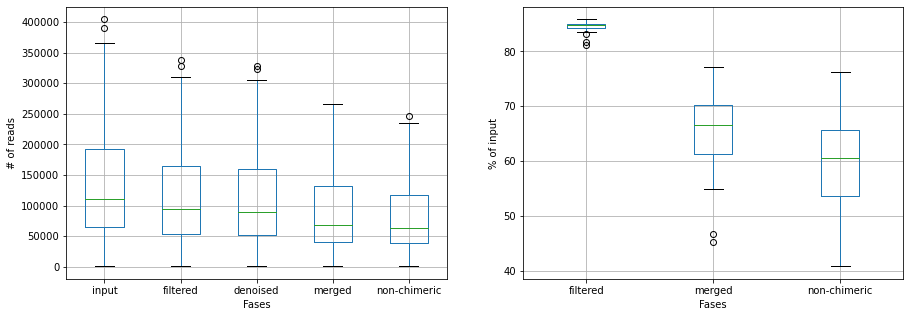

In [16]:
plot_stats_box(stat, os.path.join(img_folder, 'step02-stats-boxplot.pdf'), total_reads_phases, percent_phases, cols)

In [17]:
stat.view(Metadata).to_dataframe().describe()[percent_phases]

,percentage of input passed filter,percentage of input merged,percentage of input non-chimeric
count,38.000000,38.000000,38.000000
mean,84.487895,65.045789,59.972632
std,0.884091,7.271594,7.981523
min,81.220000,45.260000,40.760000
25%,84.270000,61.335000,53.677500
50%,84.720000,66.560000,60.535000
75%,84.947500,70.265000,65.665000
max,85.840000,77.110000,76.220000


In [18]:
stat_view

<visualization: Visualization uuid: b65d0217-3812-4e4c-b5d7-a68d244ff529>

In [19]:
# new_stat = Artifact.load('/home/lauro/nupeb/redemicro/experiments/thayane-feces-01/qiime-artifacts/dada2-stat.qza')
# # new_view, = metadata_actions.tabulate(input=new_stat.view(Metadata))
# # plot_stats_box(old_stat)

# old_stat = Artifact.load('/home/lauro/nupeb/dados_brutos_rede_genoma/experiments/fezes-phred_20-tf_0-tr_0-lap_4/fezes_dada2_stat.qza')
# # old_view, = metadata_actions.tabulate(input=old_stat.view(Metadata))
# # plot_stats_box(old_stat)

# plot_stats_box_pairs(old_stat, new_stat)